In [1]:
from mpi4py import MPI
import gmsh
import numpy as np
from scipy.spatial import cKDTree
import pyvista as pv
from dolfinx import plot

Lx, Ly = 1.0, 1.0

In [25]:
from dolfinx import mesh, fem
import ufl
import numpy as np
from dolfinx.io import gmsh as gmshio
from mpi4py import MPI

# ---------------------------------------------------------------------
# 1. Mesh and tags (same mesh as reference)
# ---------------------------------------------------------------------
ref = 4
filename = f"regular_mesh_{ref}.msh"
msh, cell_markers, facet_markers = gmshio.read_from_msh(filename, MPI.COMM_WORLD, 0, gdim=2)[0:3]

tdim = msh.topology.dim  # 2
fdim = tdim - 1          # 1

lc = 1.0 / (2**ref)      # mesh size
h = lc

omega = msh

# ---------------------------------------------------------------------
# 2. Function space (standard CG on the bulk only)
# ---------------------------------------------------------------------
order = 1
V = fem.functionspace(omega, ("Lagrange", order))

# ---------------------------------------------------------------------
# 3. Trial / Test / Solution function
# ---------------------------------------------------------------------
phi = ufl.TestFunction(V)
p = fem.Function(V, name="p")
dp = ufl.TrialFunction(V)

# ---------------------------------------------------------------------
# 4. Coordinates and data
# ---------------------------------------------------------------------
x = ufl.SpatialCoordinate(omega)
# f_m = fem.Constant(omega, 0.0)
# f_m = 2*(x[1] - x[1]**2 + x[0] - x[0]**2)
f_m = x[1]
def f_callable(x):
    return x[1]

f = fem.Function(V)
f.interpolate(f_callable)
# create function
k_m = fem.Function(V, name="kappa")

def k_callable(x):
    # x is array with shape (gdim, N). compute scalar per point, return shape (1,N)
    vals = 2*(x[0])
    return vals[np.newaxis, :]

k_m.interpolate(k_callable)

kappa = 1.0
# k_m = fem.Constant(omega, kappa)  # bulk permeability

dx = ufl.Measure("dx", domain=omega)

# compute domain bbox to locate sides
coords = omega.geometry.x
xx = coords[:, 0]
yy = coords[:, 1]
xmin, xmax = xx.min(), xx.max()
ymin, ymax = yy.min(), yy.max()

tol = 1e-10 * max(xmax - xmin, ymax - ymin)

# locate boundary facets for bottom (y = ymin) and top (y = ymax)
bottom_facets = mesh.locate_entities_boundary(
    omega, fdim, lambda x: np.isclose(x[1], ymin, atol=tol)
)
top_facets = mesh.locate_entities_boundary(
    omega, fdim, lambda x: np.isclose(x[1], ymax, atol=tol)
)

# create meshtags for those Neumann parts (optional — kept for clarity)
indices = np.concatenate([bottom_facets, top_facets]).astype(np.int32)
values = np.concatenate([
    np.full(bottom_facets.shape, 10, dtype=np.int32),  # bottom tag = 10
    np.full(top_facets.shape,    20, dtype=np.int32),  # top tag    = 20
])
neumann_tags = mesh.meshtags(omega, fdim, indices, values)

# boundary measure (we'll use ds over the whole boundary with conditional g_N)
dsN = ufl.Measure("ds", domain=omega)  # we integrate g_N over the boundary

# Neumann data as conditional on the y coordinate (same as reference)
# g_N = ufl.conditional(
#     ufl.lt(abs(x[1] - ymax), tol),
#     -1.0,                                # top
#     ufl.conditional(
#         ufl.lt(abs(x[1] - ymin), tol),
#         2.0,                             # bottom
#         0.0                              # elsewhere
#     ),
# )

# ---------------------------------------------------------------------
# 5. Weak form (standard Darcy / Poisson form)
# ---------------------------------------------------------------------
a = ufl.inner(k_m * ufl.grad(dp), ufl.grad(phi)) * dx
L = f_m * phi * dx
# L -= g_N * phi * dsN

# Form for assembling (bilinear/trilinear functions expect TrialFunction in a)
A_form = ufl.inner(k_m * ufl.grad(dp), ufl.grad(phi)) * dx
b_form = L

# ---------------------------------------------------------------------
# 6. Dirichlet BCs (left/right like reference)
# ---------------------------------------------------------------------
# locate dofs on each side
left_dofs   = fem.locate_dofs_geometrical(V, lambda x: np.isclose(x[0], xmin, atol=tol))
right_dofs  = fem.locate_dofs_geometrical(V, lambda x: np.isclose(x[0], xmax, atol=tol))
top_dofs  = fem.locate_dofs_geometrical(V, lambda x: np.isclose(x[1], ymax, atol=tol))
bottom_dofs  = fem.locate_dofs_geometrical(V, lambda x: np.isclose(x[1], ymin, atol=tol))

all_dofs = np.unique(np.concatenate([left_dofs, right_dofs]))
dof_coords = V.tabulate_dof_coordinates()

p_bc_fun = fem.Function(V)
p_bc_fun.x.array[left_dofs] = 0.0
p_bc_fun.x.array[right_dofs] = dof_coords[right_dofs, 1] / 2.0
# p_bc_fun.x.array[top_dofs] = 0.0
# p_bc_fun.x.array[bottom_dofs] = 0.0

bc = fem.dirichletbc(p_bc_fun, all_dofs)
bcs = [bc]

# ---------------------------------------------------------------------
# 7. Solve linear problem using dolfinx.fem.petsc.LinearProblem
# ---------------------------------------------------------------------
from dolfinx.fem import petsc

linear_problem = petsc.LinearProblem(
    a=A_form,
    L=b_form,
    bcs=bcs,
    petsc_options={
        "ksp_type": "preonly",
        "pc_type": "lu",
        "pc_factor_mat_solver_type": "mumps",
        "ksp_error_if_not_converged": True,
    },
    petsc_options_prefix="pmix_"
)

p_sol = linear_problem.solve()
p_sol.name = "pressure"

# optionally copy into p Function if you prefer
p.x.array[:] = p_sol.x.array[:]

# ---------------------------------------------------------------------
# 8. Diagnostics
# ---------------------------------------------------------------------
print("DOFs in V:", V.dofmap.index_map.size_global)


Info    : Reading 'regular_mesh_4.msh'...
Info    : 2337 entities
Info    : 289 nodes
Info    : 2337 elements
Info    : Done reading 'regular_mesh_4.msh'
DOFs in V: 289


In [26]:
# Access mesh geometry
tdim = omega.topology.dim

# Gather coordinates and connectivity
omega_geometry = omega.geometry.x[:,0:2]  # global array of vertex coords
# Build cell->vertex mapping (fast access)
# Using dolfinx.Cell to get connectivity is more robust, but below uses mesh.topology
cells = omega.topology.connectivity(0, tdim)  # vertices -> cells
# Instead get cell->vertex mapping via mesh.topology.index_map?
# Simpler: use mesh.geometry.x with mesh.topology.connectivity(tdim, 0)
ctv = omega.topology.connectivity(tdim, 0)
if ctv is None:
    omega.topology.create_connectivity(tdim, 0)
    ctv = omega.topology.connectivity(tdim, 0)
# ctv.array() gives flattened vertex indices -> need per-cell view
# There's a helper to get cell entity indices
num_cells = omega.topology.index_map(tdim).size_local  # per-rank local count
# We'll iterate over local cells only
local_cells = np.arange(num_cells, dtype=np.int32)

# For evaluating u_h and kappa, we can use u_h.x.array if needed.
# But easier: create a point evaluation lambda to get value at a point
from dolfinx.fem import Function
u_func = p_sol
local_fluxes = {}
V_dofmap = V.dofmap.index_map.local_range  # not directly used; we'll query dofs per cell

# Get dof indices per cell
# Using dolfinx.fem.locate_dofs_topological is one option, but below we get cell_dofs
dofmap = V.dofmap
# But to avoid uncertain reshape semantics, use mesh.topology.connectivity(tdim, 0).entities
# Simpler robust approach: use dolfinx.mesh.cells() to get local cells vertex indices
try:
    from dolfinx.mesh import cells as dolfinx_cells
    local_cell_vertices = dolfinx_cells(mesh)
except Exception:
    # fallback: create by slicing connectivity
    # arr = ctv.array
    # local_cell_vertices = arr.reshape((-1, 3))
    local_cell_vertices = np.array([ctv.links(c) for c in range(ctv.num_nodes)])

In [27]:
import numpy as np
import torch
import torch.nn as nn
import cma
from tqdm import tqdm
import basix
from dolfinx import default_scalar_type, mesh as dmesh

# ---------------------------------------------------------
# 1. Define a small NN for flux (or flux correction)
# ---------------------------------------------------------

class FluxNet(nn.Module):
    def __init__(self, in_dim=1, out_dim=1, hidden_dim=32):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, out_dim),
        )

    def forward(self, x):
        # x: tensor of shape (N, in_dim)
        return self.net(x)


net = FluxNet(in_dim=2, out_dim=2, hidden_dim=16)


# ---------------------------------------------------------
# 2. Utilities to flatten / unflatten parameters
# ---------------------------------------------------------

def get_flat_params_from(net: nn.Module) -> np.ndarray:
    """
    Returns a 1D numpy array containing all parameters of the network.
    """
    with torch.no_grad():
        vec = torch.nn.utils.parameters_to_vector(net.parameters())
    return vec.cpu().numpy()


def set_flat_params_to(net: nn.Module, theta: np.ndarray):
    """
    Loads a 1D numpy array `theta` back into the network parameters.
    """
    theta_torch = torch.tensor(theta, dtype=torch.float32)
    with torch.no_grad():
        torch.nn.utils.vector_to_parameters(theta_torch, net.parameters())


# ---------------------------------------------------------
# 3. Define a loss function for CMA-ES (gradient-free)
# ---------------------------------------------------------

# Precompute sample points (these play the role of quadrature points)
# x_np = np.linspace(0.0, 1.0, 128, endpoint=True)
x_np = V.tabulate_dof_coordinates()
x_torch = torch.tensor(x_np, dtype=torch.float32).view(-1, 1)


def compute_flux_loss(net: nn.Module, it) -> float:
    """
    L = sum_j ( ∫_{∂D_j} r_θ · n  +  ∫_{∂D_j} q_cg · n  -  ∫_{D_j} f )^2

    For each cell D_j, we:
      - build a one-cell local mesh with that cell's vertices
      - interpolate the NN correction r_θ into a vector CG2 space
      - compute ∫_{∂D_j} r_θ · n via fem.assemble_scalar on the local mesh
      - use precomputed cell_flux_cg[j] and cell_rhs[j]
    """
    gdim = omega_geometry.shape[1]

    total_loss_local = 0.0
    # print("Iteration: ", it)
    for local_cell_idx, cell_verts in enumerate(local_cell_vertices):
        # -------------------------------------------------
        # 1. Build one-cell local mesh for this element
        # -------------------------------------------------
        coords = omega_geometry[cell_verts]  # shape (3, gdim)
        loc_cells = np.array([[0, 1, 2]], dtype=np.int64)

        coord_el = basix.ufl.element(
            "Lagrange", "triangle", 1, shape=(gdim,)
        )

        local_mesh = dmesh.create_mesh(
            MPI.COMM_SELF, loc_cells, coord_el, coords
        )

        # -------------------------------------------------
        # 2. Local vector CG2 space for r_θ
        # -------------------------------------------------
        # Vector-valued CG2 (shape=(gdim,))
        V_loc = fem.functionspace(local_mesh, ("CG", order+1, (gdim,)))
        r_loc = fem.Function(V_loc)

        # -------------------------------------------------
        # 3. Interpolate NN into r_loc via dof coordinates
        # -------------------------------------------------
        x_loc = V_loc.tabulate_dof_coordinates()[:,0:2]  # (Ndofs, gdim)
        x_loc_torch = torch.tensor(x_loc, dtype=torch.float32)      # NN input

        r_vals_torch = net(x_loc_torch)                             # (Ndofs, gdim)
        r_vals = r_vals_torch.detach().cpu().numpy().reshape(-1)

        # assign to local FEM function
        r_loc.x.array[:] = r_vals.astype(default_scalar_type)

        # -------------------------------------------------
        # 4. Compute ∫_{∂D_j} r_θ · n ds on local mesh
        # -------------------------------------------------
        n_K = ufl.FacetNormal(local_mesh)
        int_r_form = fem.form(ufl.dot(r_loc, n_K) * ufl.ds)
        int_r_local = fem.assemble_scalar(int_r_form)

        # -------------------------------------------------
        # 5. Combine with q_cg and f (precomputed per cell)
        # -------------------------------------------------
        P_loc = fem.functionspace(local_mesh, ("CG", order))
        p_K = fem.Function(P_loc)

        # DOFs on this cell in the global space
        global_dofs = V.dofmap.cell_dofs(local_cell_idx)

        # DOFs on the (only) cell in the local space
        local_dofs = P_loc.dofmap.cell_dofs(0)

        p_K.x.array[local_dofs] = p_sol.x.array[global_dofs]
        p_K.x.scatter_forward()

        k_m_loc = fem.Function(P_loc)
        k_m_loc.x.array[local_dofs] = k_m.x.array[global_dofs]

        q_CG = -k_m_loc * ufl.grad(p_K)
        int_qcg = fem.assemble_scalar(
                    fem.form(ufl.dot(q_CG, n_K) * ufl.ds(domain=local_mesh))
                )   # ∫_{∂D_j} q_cg · n
        
        f_m_loc = fem.Function(P_loc)
        f_m_loc.x.array[local_dofs] = f.x.array[global_dofs]
        f_m_loc.x.scatter_forward()
        int_f   = fem.assemble_scalar(fem.form(f_m_loc * ufl.dx(domain=local_mesh)))       # ∫_{D_j} f

        residual_j = int_r_local + int_qcg - int_f
        total_loss_local += float(residual_j**2)

    # -----------------------------------------------------
    # 6. Sum over MPI ranks (if mesh is parallel)
    # -----------------------------------------------------
    # total_loss = mesh.comm.allreduce(total_loss_local, op=MPI.SUM)
    total_loss = total_loss_local

    return float(total_loss)


def objective(theta: np.ndarray, it) -> float:
    """
    Wrapper for CMA-ES: given a candidate parameter vector theta,
    put it into the net, evaluate the FEM-based loss, and return it.
    """
    set_flat_params_to(net, theta)
    loss_value = compute_flux_loss(net, it)
    return loss_value


# ---------------------------------------------------------
# 4. Run CMA-ES to "train" the network gradient-free
# ---------------------------------------------------------

# Initial parameter vector
theta0 = get_flat_params_from(net)

# Initial step size for CMA-ES
sigma0 = 0.1

# Create CMA-ES optimizer
es = cma.CMAEvolutionStrategy(theta0, sigma0)

max_generations = 50

mse_it = []
for gen in tqdm(range(max_generations)):
    # Ask for a population of candidate solutions
    candidate_thetas = es.ask()

    # Evaluate objective for each candidate (can be parallelized if you want)
    values = [objective(theta, gen) for theta in candidate_thetas]

    # Tell CMA-ES the candidate solutions and their objective values
    es.tell(candidate_thetas, values)

    # (Optional) print progress
    es.disp()
    mse_it.append(es.result.fbest)

# Get best parameters found
best_theta = es.result.xbest
best_value = es.result.fbest

print("Best objective value:", best_value)

# Load the best parameters into the network
set_flat_params_to(net, best_theta)

# Now `net` is your trained, gradient-free NN.


(10_w,21)-aCMA-ES (mu_w=6.2,w_1=27%) in dimension 354 (seed=513365, Mon Jan 26 20:08:10 2026)


  0%|          | 0/50 [00:00<?, ?it/s]

Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     21 7.118087269081754e-03 1.0e+00 9.83e-02  1e-01  1e-01 0:46.4


  2%|▏         | 1/50 [00:46<37:55, 46.44s/it]

    2     42 6.859557155477168e-03 1.0e+00 9.69e-02  1e-01  1e-01 1:32.9


  4%|▍         | 2/50 [01:32<37:08, 46.44s/it]

    3     63 6.531496924864801e-03 1.0e+00 9.56e-02  1e-01  1e-01 2:17.9


  6%|▌         | 3/50 [02:17<35:53, 45.82s/it]

    4     84 6.058873493798991e-03 1.0e+00 9.44e-02  9e-02  9e-02 3:04.0


  8%|▊         | 4/50 [03:03<35:11, 45.89s/it]

    5    105 5.759868111230558e-03 1.0e+00 9.33e-02  9e-02  9e-02 3:49.5


 10%|█         | 5/50 [03:49<34:18, 45.75s/it]

    6    126 5.648325812836150e-03 1.0e+00 9.23e-02  9e-02  9e-02 4:38.2


 12%|█▏        | 6/50 [04:38<34:18, 46.79s/it]

    7    147 5.381365985193912e-03 1.0e+00 9.14e-02  9e-02  9e-02 5:22.6


 14%|█▍        | 7/50 [05:22<32:58, 46.01s/it]

    8    168 5.347853611174034e-03 1.0e+00 9.06e-02  9e-02  9e-02 6:05.9


 16%|█▌        | 8/50 [06:05<31:35, 45.13s/it]

    9    189 5.314761689845125e-03 1.0e+00 8.99e-02  9e-02  9e-02 6:56.4


 18%|█▊        | 9/50 [06:56<31:59, 46.82s/it]

   10    210 5.173128225361041e-03 1.0e+00 8.91e-02  9e-02  9e-02 7:40.1


 20%|██        | 10/50 [07:40<30:34, 45.85s/it]

   11    231 5.112266029700275e-03 1.0e+00 8.85e-02  9e-02  9e-02 8:27.1


 22%|██▏       | 11/50 [08:27<30:01, 46.20s/it]

   12    252 4.971574352113041e-03 1.0e+00 8.79e-02  9e-02  9e-02 9:17.1


 24%|██▍       | 12/50 [09:17<29:59, 47.37s/it]

   13    273 4.738400475324980e-03 1.0e+00 8.73e-02  9e-02  9e-02 10:02.1


 26%|██▌       | 13/50 [10:02<28:45, 46.63s/it]

   14    294 4.643629884417380e-03 1.0e+00 8.69e-02  9e-02  9e-02 10:48.5


 28%|██▊       | 14/50 [10:48<27:55, 46.56s/it]

   15    315 4.397741760908935e-03 1.0e+00 8.65e-02  9e-02  9e-02 11:37.4


 30%|███       | 15/50 [11:37<27:34, 47.28s/it]

   16    336 4.344660559591001e-03 1.0e+00 8.61e-02  9e-02  9e-02 12:24.2


 32%|███▏      | 16/50 [12:24<26:42, 47.15s/it]

   17    357 4.084007117853731e-03 1.0e+00 8.57e-02  9e-02  9e-02 13:09.5


 34%|███▍      | 17/50 [13:09<25:37, 46.58s/it]

   18    378 3.979990802471174e-03 1.0e+00 8.54e-02  9e-02  9e-02 13:54.8


 36%|███▌      | 18/50 [13:54<24:38, 46.19s/it]

   19    399 3.731939302551132e-03 1.0e+00 8.52e-02  9e-02  9e-02 14:40.9


 38%|███▊      | 19/50 [14:40<23:50, 46.16s/it]

   20    420 3.660236240640766e-03 1.0e+00 8.49e-02  8e-02  8e-02 15:32.4


 40%|████      | 20/50 [15:32<23:53, 47.78s/it]

   21    441 3.558575928077136e-03 1.0e+00 8.46e-02  8e-02  8e-02 16:50.6


 42%|████▏     | 21/50 [16:50<27:29, 56.89s/it]

   22    462 3.318517256812175e-03 1.0e+00 8.44e-02  8e-02  8e-02 18:11.1


 44%|████▍     | 22/50 [18:11<29:51, 63.99s/it]

   23    483 3.144730237080953e-03 1.0e+00 8.41e-02  8e-02  8e-02 19:28.3


 46%|████▌     | 23/50 [19:28<30:34, 67.96s/it]

   24    504 3.080516431826681e-03 1.0e+00 8.40e-02  8e-02  8e-02 20:44.6


 48%|████▊     | 24/50 [20:44<30:32, 70.46s/it]

   25    525 2.833722226319918e-03 1.0e+00 8.38e-02  8e-02  8e-02 21:59.1


 50%|█████     | 25/50 [21:59<29:51, 71.68s/it]

   26    546 2.551349874987944e-03 1.0e+00 8.37e-02  8e-02  8e-02 23:12.9


 52%|█████▏    | 26/50 [23:12<28:55, 72.32s/it]

   27    567 2.592663558009395e-03 1.0e+00 8.36e-02  8e-02  8e-02 24:26.9


 54%|█████▍    | 27/50 [24:26<27:54, 72.82s/it]

   28    588 2.510483582592401e-03 1.0e+00 8.35e-02  8e-02  8e-02 25:39.8


 56%|█████▌    | 28/50 [25:39<26:42, 72.84s/it]

   29    609 2.376232947213923e-03 1.0e+00 8.35e-02  8e-02  8e-02 26:54.4


 58%|█████▊    | 29/50 [26:54<25:40, 73.37s/it]

   30    630 2.330554531803346e-03 1.0e+00 8.34e-02  8e-02  8e-02 28:11.1


 60%|██████    | 30/50 [28:11<24:47, 74.37s/it]

   31    651 2.207291821270619e-03 1.0e+00 8.34e-02  8e-02  8e-02 29:29.3


 62%|██████▏   | 31/50 [29:29<23:54, 75.51s/it]

   32    672 2.144225744845890e-03 1.0e+00 8.34e-02  8e-02  8e-02 30:45.4


 64%|██████▍   | 32/50 [30:45<22:42, 75.69s/it]

   33    693 2.046653949739873e-03 1.0e+00 8.35e-02  8e-02  8e-02 32:04.1


 66%|██████▌   | 33/50 [32:04<21:42, 76.61s/it]

   34    714 1.753955527142474e-03 1.0e+00 8.35e-02  8e-02  8e-02 33:18.6


 68%|██████▊   | 34/50 [33:18<20:15, 75.98s/it]

   35    735 1.848501849375425e-03 1.0e+00 8.36e-02  8e-02  8e-02 34:34.9


 70%|███████   | 35/50 [34:34<19:00, 76.06s/it]

   36    756 1.559601544741406e-03 1.0e+00 8.37e-02  8e-02  8e-02 35:49.2


 72%|███████▏  | 36/50 [35:49<17:37, 75.53s/it]

   37    777 1.534646612442727e-03 1.0e+00 8.39e-02  8e-02  8e-02 37:02.4


 74%|███████▍  | 37/50 [37:02<16:13, 74.85s/it]

   38    798 1.453684645090522e-03 1.0e+00 8.40e-02  8e-02  8e-02 38:21.3


 76%|███████▌  | 38/50 [38:21<15:12, 76.06s/it]

   39    819 1.307676585745302e-03 1.0e+00 8.43e-02  8e-02  8e-02 39:40.1


 78%|███████▊  | 39/50 [39:40<14:05, 76.89s/it]

   40    840 1.048154177880240e-03 1.0e+00 8.45e-02  8e-02  8e-02 40:57.8


 80%|████████  | 40/50 [40:57<12:51, 77.14s/it]

   41    861 9.448500553121643e-04 1.1e+00 8.47e-02  8e-02  8e-02 42:20.4


 82%|████████▏ | 41/50 [42:20<11:48, 78.78s/it]

   42    882 9.087648078582170e-04 1.1e+00 8.49e-02  8e-02  9e-02 43:39.4


 84%|████████▍ | 42/50 [43:39<10:30, 78.84s/it]

   43    903 1.096144153206094e-03 1.1e+00 8.51e-02  8e-02  9e-02 45:01.7


 86%|████████▌ | 43/50 [45:01<09:19, 79.89s/it]

   44    924 1.059681833677472e-03 1.1e+00 8.53e-02  9e-02  9e-02 46:29.0


 88%|████████▊ | 44/50 [46:29<08:12, 82.10s/it]

   45    945 9.839585194899351e-04 1.1e+00 8.55e-02  9e-02  9e-02 47:50.7


 90%|█████████ | 45/50 [47:50<06:49, 81.99s/it]

   46    966 9.382779924323826e-04 1.1e+00 8.57e-02  9e-02  9e-02 49:14.3


 92%|█████████▏| 46/50 [49:14<05:29, 82.47s/it]

   47    987 9.490549998552464e-04 1.1e+00 8.59e-02  9e-02  9e-02 50:35.1


 94%|█████████▍| 47/50 [50:35<04:05, 81.96s/it]

   48   1008 8.995231680021061e-04 1.1e+00 8.61e-02  9e-02  9e-02 51:56.3


 96%|█████████▌| 48/50 [51:56<02:43, 81.73s/it]

   49   1029 1.031643048795393e-03 1.1e+00 8.62e-02  9e-02  9e-02 53:18.3


 98%|█████████▊| 49/50 [53:18<01:21, 81.81s/it]

   50   1050 8.647342758246092e-04 1.1e+00 8.64e-02  9e-02  9e-02 54:38.6


100%|██████████| 50/50 [54:38<00:00, 65.58s/it]

Best objective value: 0.0008647342758246092


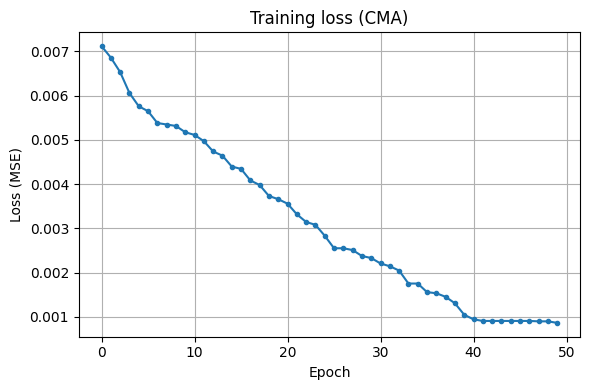

In [32]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
plt.plot(mse_it, marker="o", markersize=3)
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.title("Training loss (CMA)")
plt.grid(True)
plt.tight_layout()
plt.show()

In [28]:
LCE_CG = []
LCE_rec = []
indices = []

LCE_CG_int = []
LCE_rec_int = []
indices_int = []
for local_cell_idx, cell_verts in enumerate(tqdm(local_cell_vertices)):
    # cell_verts are global vertex indices
    coords = omega_geometry[cell_verts]  # shape (3,2)
    centroid = np.mean(coords, axis=0).reshape(1,-1)

    loc_cells = np.array([[0, 1, 2]], dtype=np.int64)

    gdim = coords.shape[1]
    coord_el = basix.ufl.element("Lagrange", "triangle", 1, shape=(gdim,))

    local_mesh = dmesh.create_mesh(
        MPI.COMM_SELF,
        loc_cells,
        coord_el,   # <-- this is the required "e" argument
        coords
    )
    cell_dofs = V.dofmap.cell_dofs(local_cell_idx)
    # -------------------------------------------------
    # 2. Local vector CG2 space for r_θ
    # -------------------------------------------------
    # Vector-valued CG2 (shape=(gdim,))
    V_loc = fem.functionspace(local_mesh, ("CG", order+1, (gdim,)))
    r_loc = fem.Function(V_loc)

    # -------------------------------------------------
    # 3. Interpolate NN into r_loc via dof coordinates
    # -------------------------------------------------
    x_loc = V_loc.tabulate_dof_coordinates()[:,0:2]  # (Ndofs, gdim)
    x_loc_torch = torch.tensor(x_loc, dtype=torch.float32)      # NN input

    r_vals_torch = net(x_loc_torch)                             # (Ndofs, gdim)
    r_vals = r_vals_torch.detach().cpu().numpy().reshape(-1)

    # assign to local FEM function
    r_loc.x.array[:] = r_vals.astype(default_scalar_type)

    # -------------------------------------------------
    # 4. Compute ∫_{∂D_j} r_θ · n ds on local mesh
    # -------------------------------------------------
    n_K = ufl.FacetNormal(local_mesh)
    int_r_form = fem.form(ufl.dot(r_loc, n_K) * ufl.ds)
    int_r_local = fem.assemble_scalar(int_r_form)

    # -------------------------------------------------
    # 5. Combine with q_cg and f (precomputed per cell)
    # -------------------------------------------------
    P_loc = fem.functionspace(local_mesh, ("CG", order))
    p_K = fem.Function(P_loc)

    # DOFs on this cell in the global space
    global_dofs = V.dofmap.cell_dofs(local_cell_idx)

    # DOFs on the (only) cell in the local space
    local_dofs = P_loc.dofmap.cell_dofs(0)

    p_K.x.array[local_dofs] = p_sol.x.array[global_dofs]
    p_K.x.scatter_forward()

    k_m_loc = fem.Function(P_loc)
    k_m_loc.x.array[local_dofs] = k_m.x.array[global_dofs]

    q_CG = -k_m_loc * ufl.grad(p_K)
    int_qcg = fem.assemble_scalar(
                fem.form(ufl.dot(q_CG, n_K) * ufl.ds(domain=local_mesh))
            )   # ∫_{∂D_j} q_cg · n
    
    f_m_loc = fem.Function(P_loc)
    f_m_loc.x.array[local_dofs] = f.x.array[global_dofs]
    f_m_loc.x.scatter_forward()
    int_f   = fem.assemble_scalar(fem.form(f_m_loc * ufl.dx(domain=local_mesh)))       # ∫_{D_j} f

    residual_j = int_r_local + int_qcg - int_f

    LCE_CG.append(int_qcg - int_f)
    LCE_rec.append(residual_j)
    indices.append(local_cell_idx)

    left_dofs_P = fem.locate_dofs_geometrical(
        P_loc, lambda x: np.isclose(x[0], xmin, atol=tol)
    )
    right_dofs_P = fem.locate_dofs_geometrical(
        P_loc, lambda x: np.isclose(x[0], xmax, atol=tol)
    )

    if (len(left_dofs_P) == 0) and (len(right_dofs_P) == 0):
        LCE_CG_int.append(int_qcg - int_f)
        LCE_rec_int.append(residual_j)
        indices_int.append(local_cell_idx)

100%|██████████| 512/512 [00:05<00:00, 97.57it/s] 


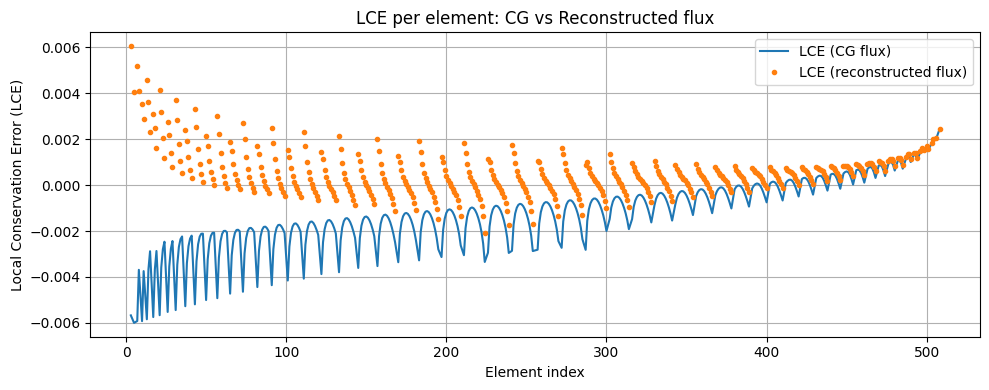

CG LCE stats: {'min': -0.006003117505676121, 'max': 0.002438592789572943, 'L1_mean_abs': 0.001492693584011395, 'L2_rms': 0.0019014356027301429}
Reconstructed LCE stats: {'min': -0.0020685685849392036, 'max': 0.006054954071063565, 'L1_mean_abs': 0.0007900207845400863, 'L2_rms': 0.0011289087457835465}


In [29]:
import matplotlib.pyplot as plt
indices_plot = np.array(indices_int, dtype=int)
LCE_CG_plot = np.array(LCE_CG_int, dtype=float)
LCE_rec_plot = np.array(LCE_rec_int, dtype=float)

# plot
plt.figure(figsize=(10,4))
plt.plot(indices_plot, LCE_CG_plot, label="LCE (CG flux)")
plt.plot(indices_plot, LCE_rec_plot, ".", label="LCE (reconstructed flux)")
plt.xlabel("Element index")
plt.ylabel("Local Conservation Error (LCE)")
plt.title("LCE per element: CG vs Reconstructed flux")
plt.legend()
plt.grid(True)
plt.tight_layout()
# out_path = "/mnt/data/lce_plot.png"
# plt.savefig(out_path)
plt.show()

# print stats & produce dataframe
def stats(arr):
    return {"min": float(arr.min()), "max": float(arr.max()), "L1_mean_abs": float(np.mean(np.abs(arr))), "L2_rms": float(np.sqrt(np.mean(arr**2)))}
print("CG LCE stats:", stats(LCE_CG_plot))
print("Reconstructed LCE stats:", stats(LCE_rec_plot))

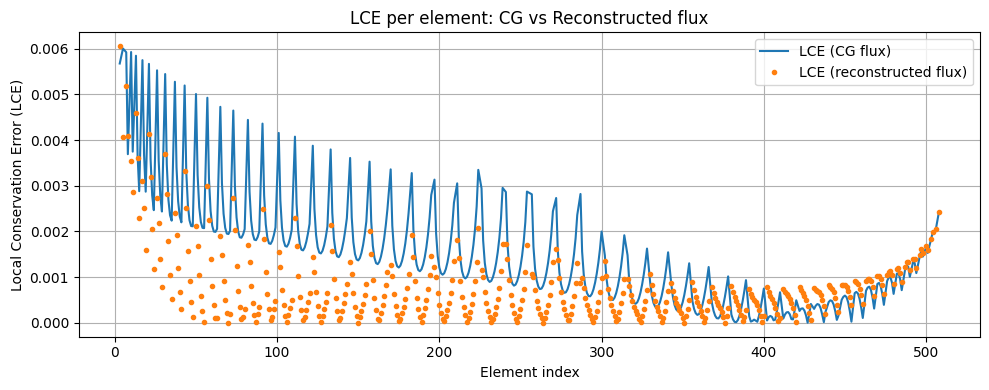

CG LCE stats: {'min': -0.006003117505676121, 'max': 0.002438592789572943, 'L1_mean_abs': 0.001492693584011395, 'L2_rms': 0.0019014356027301429}
Reconstructed LCE stats: {'min': -0.0020685685849392036, 'max': 0.006054954071063565, 'L1_mean_abs': 0.0007900207845400863, 'L2_rms': 0.0011289087457835465}


In [30]:
import matplotlib.pyplot as plt
indices_plot = np.array(indices_int, dtype=int)
LCE_CG_plot = np.array(LCE_CG_int, dtype=float)
LCE_rec_plot = np.array(LCE_rec_int, dtype=float)

# plot
plt.figure(figsize=(10,4))
plt.plot(indices_plot, np.abs(LCE_CG_plot), label="LCE (CG flux)")
plt.plot(indices_plot, np.abs(LCE_rec_plot), ".", label="LCE (reconstructed flux)")
plt.xlabel("Element index")
plt.ylabel("Local Conservation Error (LCE)")
plt.title("LCE per element: CG vs Reconstructed flux")
plt.legend()
plt.grid(True)
plt.tight_layout()
# out_path = "/mnt/data/lce_plot.png"
# plt.savefig(out_path)
plt.show()

# print stats & produce dataframe
def stats(arr):
    return {"min": float(arr.min()), "max": float(arr.max()), "L1_mean_abs": float(np.mean(np.abs(arr))), "L2_rms": float(np.sqrt(np.mean(arr**2)))}
print("CG LCE stats:", stats(LCE_CG_plot))
print("Reconstructed LCE stats:", stats(LCE_rec_plot))

In [1]:
import math
[
            0.5 * (1.0 - 1.0 / math.sqrt(3.0)),
            0.5 * (1.0 + 1.0 / math.sqrt(3.0)),
        ]

[0.21132486540518708, 0.7886751345948129]